# rental bikes in the Capital Bikeshare system, as well as the corresponding weather and seasonal information, build three regression models to predict the total rental bikes required on a specific day and choose the one with the best coefficient of determination (r squared score).

In [148]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')



In [149]:

data= pd.read_csv('day.csv')

In [150]:
data.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [151]:
data.shape

(731, 16)

In [152]:
data.rename(columns={'dteday':'datetime'},inplace=True)

#Typecasting the datetime and numerical attributes

In [153]:
data['datetime']=pd.to_datetime(data.datetime)
data['season']=data.season.astype('category')
data['yr']=data.yr.astype('category')
data['mnth']=data.mnth.astype('category')
data['holiday']=data.holiday.astype('category')
data['weekday']=data.weekday.astype('category')
data['workingday']=data.workingday.astype('category')
data['weathersit']=data.weathersit.astype('category')

In [154]:
data.describe() 

,instant,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [155]:
data.isnull().sum() # finding the count of missing values from different columns

instant       0
datetime      0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

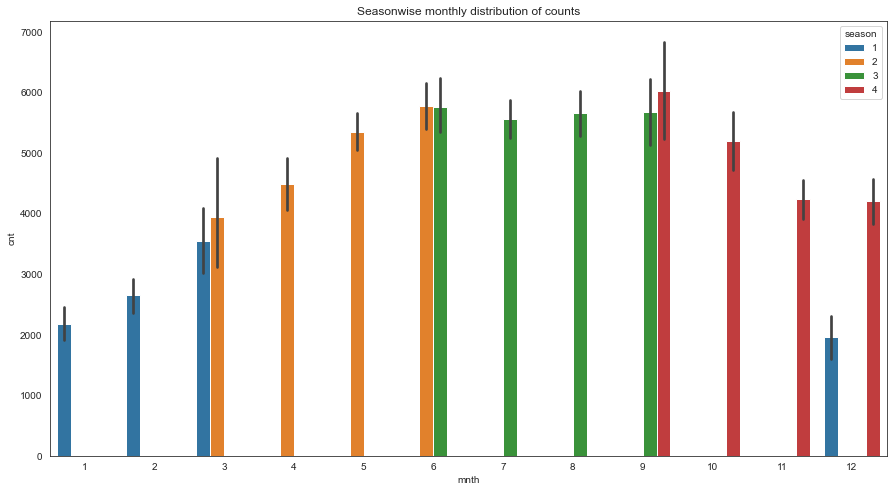

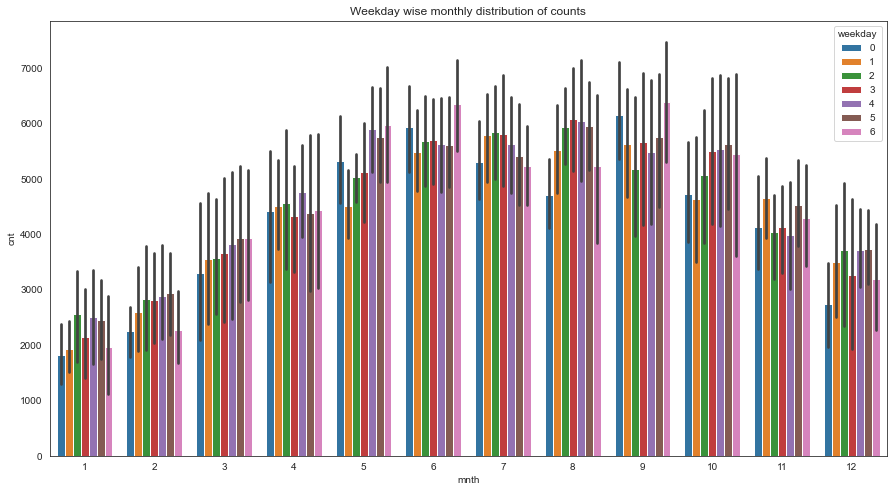

In [156]:
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='mnth',y='cnt',data=data[['mnth','cnt','season']],hue='season',ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()
#Bar plot for weekday wise monthly distribution of counts
fig,ax1=plt.subplots(figsize=(15,8))
sns.barplot(x='mnth',y='cnt',data=data[['mnth','cnt','weekday']],hue='weekday',ax=ax1)
ax1.set_title('Weekday wise monthly distribution of counts')
plt.show()

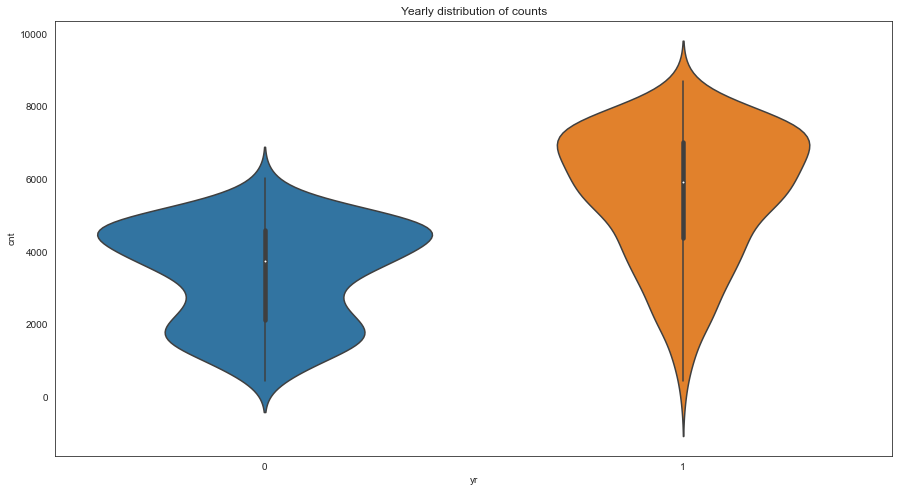

In [157]:
fig,ax=plt.subplots(figsize=(15,8))
#Violin plot for yearly distribution of counts
sns.violinplot(x='yr',y='cnt',data=data[['yr','cnt']])
ax.set_title('Yearly distribution of counts')
plt.show()


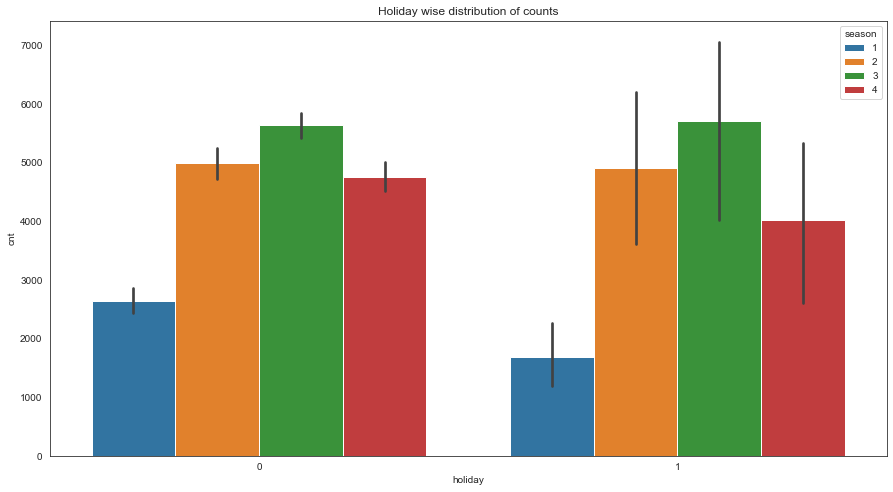

In [158]:
fig,ax=plt.subplots(figsize=(15,8))
#Barplot for Holiday distribution of counts
sns.barplot(data=data,x='holiday',y='cnt',hue='season')
ax.set_title('Holiday wise distribution of counts')
plt.show()

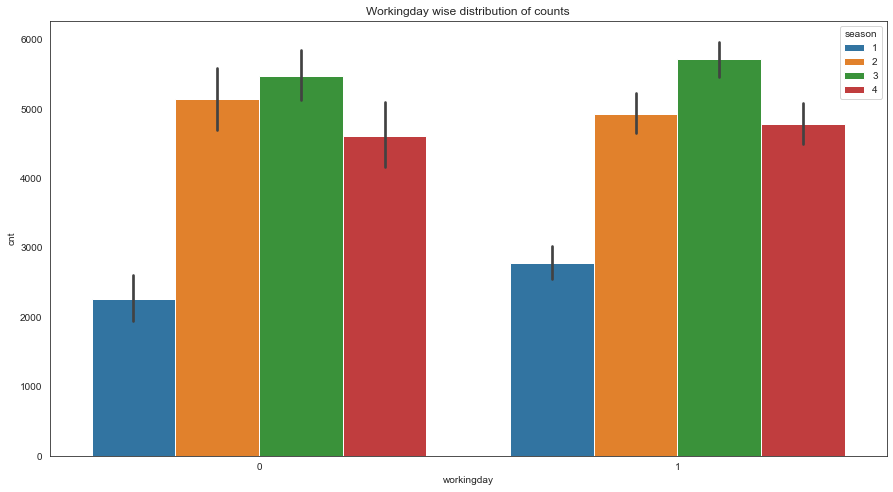

In [159]:
fig,ax=plt.subplots(figsize=(15,8))
#Bar plot for workingday distribution of counts
sns.barplot(data=data,x='workingday',y='cnt',hue='season')
ax.set_title('Workingday wise distribution of counts')
plt.show()

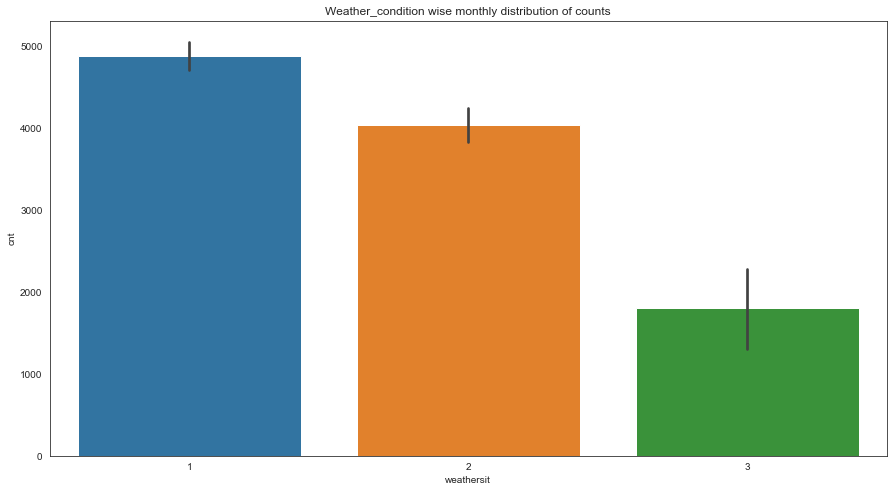

In [160]:
fig,ax1=plt.subplots(figsize=(15,8))
#Bar plot for weather_condition distribution of counts
sns.barplot(x='weathersit',y='cnt',data=data[['mnth','cnt','weathersit']],ax=ax1)
ax1.set_title('Weather_condition wise monthly distribution of counts')
plt.show()

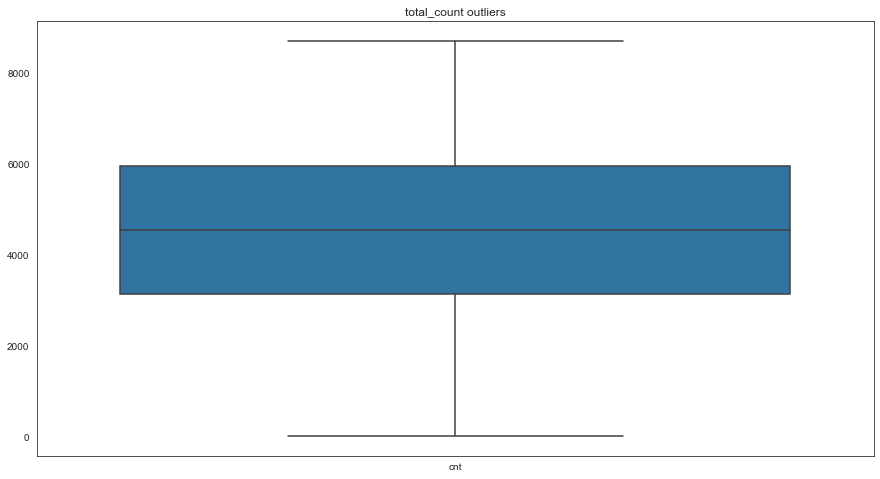

In [161]:
fig,ax=plt.subplots(figsize=(15,8))
#Boxplot for total_count outliers
sns.boxplot(data=data[['cnt']])
ax.set_title('total_count outliers')
plt.show()

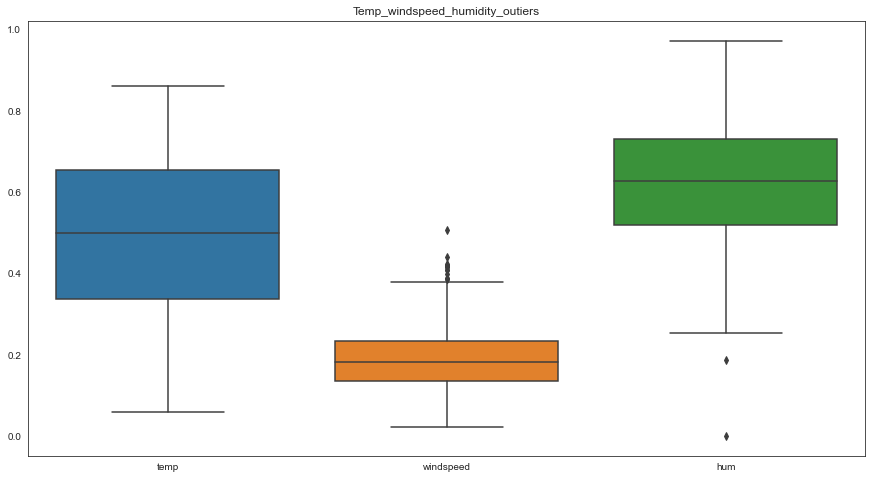

In [162]:
fig,ax=plt.subplots(figsize=(15,8))
#Box plot for Temp_windspeed_humidity_outliers
sns.boxplot(data=data[['temp','windspeed','hum']])
ax.set_title('Temp_windspeed_humidity_outiers')
plt.show()

# Replace and impute the outliers

In [163]:

from fancyimpute import KNN

#create dataframe for outliers
wind_hum=pd.DataFrame(data,columns=['windspeed','hum'])
 #Cnames for outliers                     
cnames=['windspeed','hum']       
                      
for i in cnames:
    q75,q25=np.percentile(wind_hum.loc[:,i],[75,25]) # Divide data into 75%quantile and 25%quantile.
    iqr=q75-q25 #Inter quantile range
    min=q25-(iqr*1.5) #inner fence
    max=q75+(iqr*1.5) #outer fence
    wind_hum.loc[wind_hum.loc[:,i]<min,:i]=np.nan  #Replace with NA
    wind_hum.loc[wind_hum.loc[:,i]>max,:i]=np.nan  #Replace with NA
#Imputating the outliers by mean Imputation
wind_hum['windspeed']=wind_hum['windspeed'].fillna(wind_hum['windspeed'].mean())
wind_hum['hum']=wind_hum['hum'].fillna(wind_hum['hum'].mean())

# Replace the original dataset to imputated data

In [164]:
data['windspeed']=data['windspeed'].replace(wind_hum['windspeed'])
#Replacing the imputated humidity
data['hum']=data['hum'].replace(wind_hum['hum'])
data.head(5)

,instant,datetime,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Normal Probability Plot

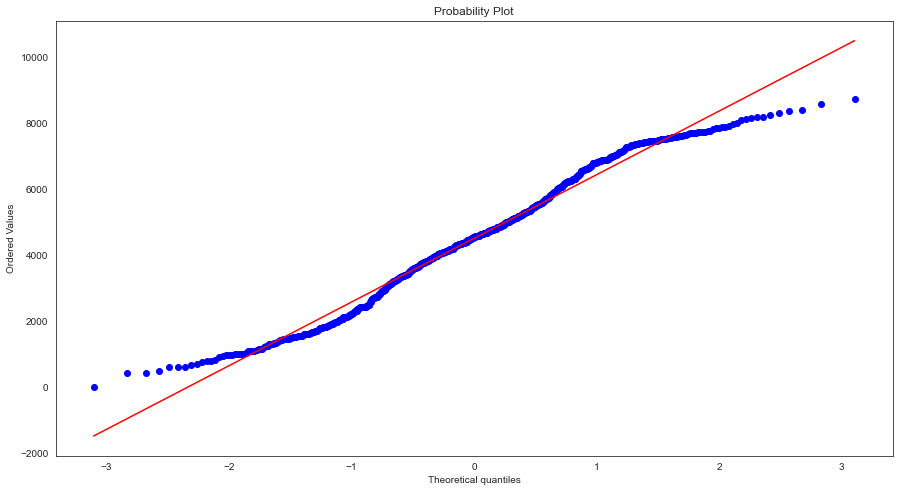

In [165]:
import scipy
from scipy import stats
#Normal plot
fig=plt.figure(figsize=(15,8))
stats.probplot(data.cnt.tolist(),dist='norm',plot=plt)
plt.show()

# The above probability plot, the some target variable data points are deviates from normality.

# Correlation matrix

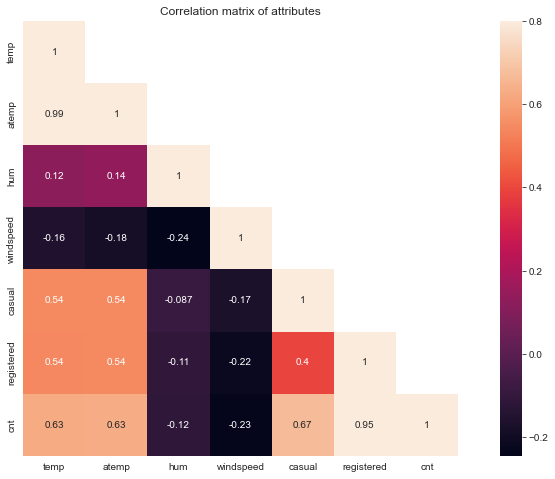

In [166]:
#Create the correlation matrix
correMtr=data[["temp","atemp","hum","windspeed","casual","registered","cnt"]].corr()
mask=np.array(correMtr)
mask[np.tril_indices_from(mask)]=False
#Heat map for correlation matrix of attributes
fig,ax=plt.subplots(figsize=(15,8))
sns.heatmap(correMtr,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
ax.set_title('Correlation matrix of attributes')
plt.show()

# From correlation plot, we can observed that some features are positively correlated or some are negatively correlated to each other. The temp and atemp are highly positively correlated to each other, it means that both are carrying same information.The total_count,casual and registered are highly positively correlated to each other. So, we are going to ignore atemp,casual and registered variable for further analysis.

# Modelling the dataset

In [167]:
from sklearn import preprocessing,metrics,linear_model
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split

# Split the dataset into train and test in the ratio of 70:30

In [168]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(data.iloc[:,0:-3],data.iloc[:,-1],test_size=0.3, random_state=42)

#Reset train index values
X_train.reset_index(inplace=True)
y_train=y_train.reset_index()

# Reset train index values
X_test.reset_index(inplace=True)
y_test=y_test.reset_index()

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
print(y_train.head())
print(y_test.head())

(511, 14) (220, 14) (511, 2) (220, 2)
   index   cnt
0    223  4905
1    684  5445
2    685  5698
3    163  5020
4    394  3624
   index   cnt
0    703  6606
1     33  1550
2    300  3747
3    456  6041
4    633  7538


# Split the features into categorical and numerical features

In [169]:
#Create a new dataset for train attributes
train_attributes=X_train[['season','mnth','yr','weekday','holiday','workingday','weathersit','hum','temp','windspeed']]
#Create a new dataset for test attributes
test_attributes=X_test[['season','mnth','yr','weekday','holiday','workingday','hum','temp','windspeed','weathersit']]
#categorical attributes
cat_attributes=['season','holiday','workingday','weathersit','yr']
#numerical attributes
num_attributes=['temp','windspeed','hum','month','weekday']

# Decoding the training attributes

In [170]:
#To get dummy variables to encode the categorical features to numeric
train_encoded_attributes=pd.get_dummies(train_attributes,columns=cat_attributes)
print('Shape of transfomed dataframe::',train_encoded_attributes.shape)
train_encoded_attributes.head(5)

Shape of transfomed dataframe:: (511, 18)


,mnth,weekday,hum,temp,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,yr_0,yr_1
0,8,5,0.415000,0.708333,0.125621,0,0,1,0,1,0,0,1,1,0,0,1,0
1,11,4,0.620417,0.321667,0.152987,0,0,0,1,1,0,0,1,0,1,0,0,1
2,11,5,0.524583,0.345000,0.171025,0,0,0,1,1,0,0,1,1,0,0,0,1
3,6,1,0.494583,0.635000,0.305350,0,1,0,0,1,0,0,1,1,0,0,1,0
4,1,1,0.400833,0.269167,0.215792,1,0,0,0,1,0,0,1,1,0,0,0,1


# Training dataset

In [171]:
#Training dataset for modelling
X_train=train_encoded_attributes
y_train=y_train.cnt.values

# Linear Regression Model

In [172]:
#training model
lr_model=linear_model.LinearRegression()
lr_model
#fit the trained model
lr_model.fit(X_train,y_train)
#Accuracy of the model
lr=lr_model.score(X_train,y_train)
print('Accuracy of the model :',lr)
print('Model coefficients :',lr_model.coef_)
print('Model intercept value :',lr_model.intercept_)

Accuracy of the model : 0.8165025087335218
Model coefficients : [  -25.40093273    69.00041734 -1021.83801516  5265.83269167
 -2556.15204574  -949.34444399   229.82675107   -79.72789531
   799.24558823   228.48467064  -228.48467064   -78.95445063
    78.95445063   761.85445399   252.23446226 -1014.08891625
  -989.30080604   989.30080604]
Model intercept value : 2195.310562348838


# Cross validation prediction

In [173]:
#Cross validation prediction
predict=cross_val_predict(lr_model,X_train,y_train,cv=3)
predict

array([ 5248.7578435 ,  5038.5615668 ,  5806.79339316,  4353.94868702,
        3738.02165465,  6781.13199665,  6258.53686563,  3802.32154757,
        4679.69060739,  3413.26938345,  5382.26926795,  3103.26413427,
        4340.14502978,  5792.02135524,  4357.90482085,  6307.47067538,
        4382.53420011,  3356.51602988,   722.55880035,   542.99629923,
        7419.07107033,  3747.2639444 ,  5282.38323084,  5494.01243603,
        6941.05375802,  7322.95928003,  3629.5886932 ,  3571.12912785,
         985.45343201,  4884.05952005,  1644.73801661,  1708.88196943,
        1689.90104258,  1295.63879625,  4891.47726849,  5507.81236621,
        6015.17425095,  4180.63057735,  5075.38404498,  5941.56769703,
        6400.40498745,  4215.81855312,  5962.38814912,  6052.71452714,
        3345.73314148,  4096.72004817,  1465.44713372,  3603.17274178,
        4587.89942466,  6650.65699064,  1719.93360965,  6128.15135134,
        6439.33525805,  3277.84008997,  4592.0786174 ,  3194.61235   ,
      

# Cross validation prediction plot

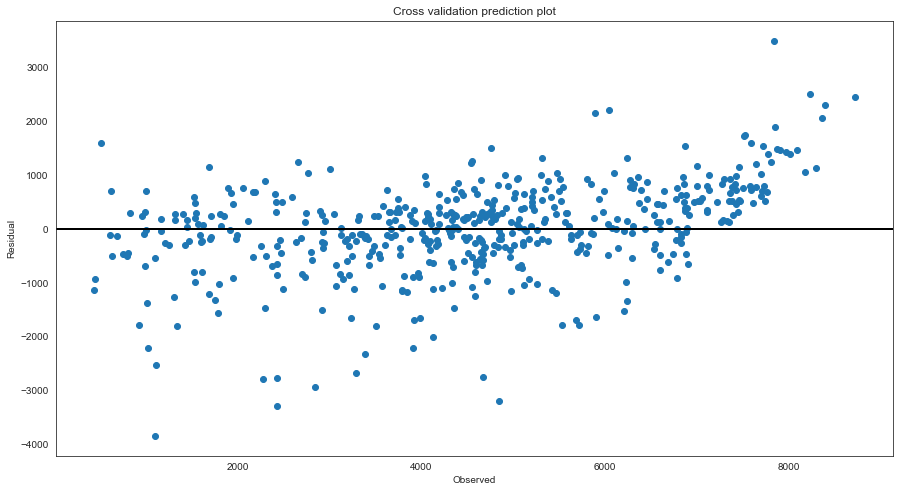

In [174]:
#Cross validation plot
fig,ax=plt.subplots(figsize=(15,8))
ax.scatter(y_train,y_train-predict)
ax.axhline(lw=2,color='black')
ax.set_title('Cross validation prediction plot')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

# R-squared and mean squared error score

In [175]:
#R-squared scores
r2_scores = cross_val_score(lr_model, X_train, y_train, cv=3)
print('R-squared scores :',np.average(r2_scores))

R-squared scores : 0.7995611885231044


# Decoding the test attributes

In [176]:
#To get dummy variables to encode the categorical features to numeric
test_encoded_attributes=pd.get_dummies(test_attributes,columns=cat_attributes)
print('Shape of transformed dataframe :',test_encoded_attributes.shape)
test_encoded_attributes.head(5)

Shape of transformed dataframe : (220, 18)


,mnth,weekday,hum,temp,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,yr_0,yr_1
0,12,2,0.733750,0.475833,0.174129,0,0,0,1,1,0,0,1,1,0,0,0,1
1,2,4,0.437826,0.186957,0.277752,1,0,0,0,1,0,0,1,1,0,0,1,0
2,10,5,0.585833,0.330833,0.229479,0,0,0,1,1,0,0,1,0,1,0,1,0
3,4,0,0.676250,0.425833,0.172267,0,1,0,0,1,0,1,0,0,1,0,0,1
4,9,2,0.570000,0.550000,0.236321,0,0,0,1,1,0,0,1,1,0,0,0,1


# Model performance on test dataset

In [177]:
#Test dataset for prediction
X_test=test_encoded_attributes
y_test=y_test.cnt.values

In [178]:
#predict the model
lr_pred=lr_model.predict(X_test)
lr_pred

array([6197.12329782, 1378.27938018, 3212.82326914, 4825.6058012 ,
       6672.2308762 , 6942.2039349 ,  693.99373527, 1929.80808599,
       6981.48110092, 6844.67173725, 2798.54559266, 2121.8457389 ,
       4465.68268321, 5486.74428544, 2189.59008463, 1827.67433934,
       2173.48158771, 7469.58027211, 5500.15015098, 2608.49336522,
       6933.20124884, 7837.10306473, 5532.48547104, 1261.13929139,
       1245.46616862, 4479.83361908, 2496.61989036, 6733.37234742,
       3854.86011528, 5802.97615092, 3103.90712661, 4252.34563973,
       6358.26561572, 6798.3144729 , 5790.26253638, 5402.54802544,
       6692.75313381, 5848.44121572, 3180.98457936,  805.80292438,
       4497.72178336, 3746.59014984, 6903.03554988, 4077.94155535,
       6907.0442079 , 1687.7942605 , 4801.49297945, 4723.9530173 ,
       6369.39948476, 4579.39869385, 3105.76669461, 2833.81705416,
       1829.36260472, 5601.65932265, 4625.78263028, 4089.39223053,
       4695.03945324, 3038.41700558, 4351.67190815, 6630.97204

# Model evaluation metrics

# Root mean square error and mean absolute error scores

In [179]:
import math
#Root mean square error 
rmse=math.sqrt(metrics.mean_squared_error(y_test,lr_pred))
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,lr_pred)
print('Root mean square error :',rmse)
print('Mean absolute error :',mae)

Root mean square error : 783.0616972625061
Mean absolute error : 594.7368430236426


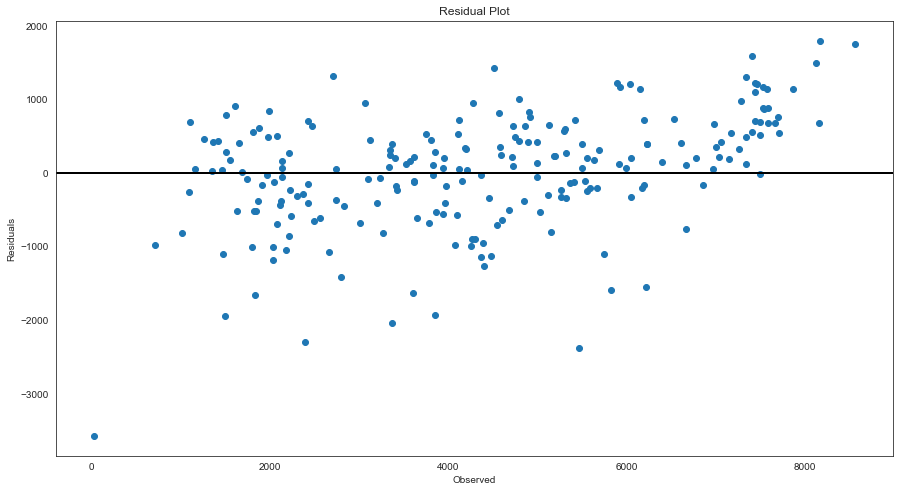

In [180]:
#Residual plot
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(y_test, y_test-lr_pred)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text("Residual Plot")
plt.show()

# Decision tree regressor

In [181]:
#training the model
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor(min_samples_split=2,max_leaf_nodes=10)


In [182]:
#Fit the trained model
dtr.fit(X_train,y_train)

DecisionTreeRegressor(max_leaf_nodes=10)

In [183]:
#Accuracy score of the model
dtr_score=dtr.score(X_train,y_train)
print('Accuracy of model :',dtr_score)

Accuracy of model : 0.8082151777539757


In [202]:
#Plot the learned model
from sklearn import tree
import pydot
import graphviz

# export the learned model to tree
dot_data = tree.export_graphviz(dtr, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

# Cross validation prediction

In [185]:
predict=cross_val_predict(dtr,X_train,y_train,cv=3)
predict

array([4513.38554217, 4592.56521739, 4592.56521739, 4513.38554217,
       2558.6       , 5388.47058824, 6824.96969697, 4592.56521739,
       4592.56521739, 3603.92857143, 6824.96969697, 3194.22222222,
       4513.38554217, 6824.96969697, 4513.38554217, 6824.96969697,
       3603.92857143, 1636.81818182, 1636.81818182, 1636.81818182,
       6824.96969697, 2558.6       , 4592.56521739, 1027.        ,
       6824.96969697, 6824.96969697, 2558.6       , 4592.56521739,
       1636.81818182, 4513.38554217, 1636.81818182, 1636.81818182,
       1636.81818182, 1636.81818182, 4513.38554217, 5388.47058824,
       6824.96969697, 4592.56521739, 4513.38554217, 6824.96969697,
       6824.96969697, 4513.38554217, 6824.96969697, 6824.96969697,
       4513.38554217, 3194.22222222, 1636.81818182, 4592.56521739,
       4513.38554217, 6824.96969697, 3194.22222222, 6824.96969697,
       6824.96969697, 3603.92857143, 4513.38554217, 1027.        ,
       1636.81818182, 4513.38554217, 1636.81818182, 4513.38554

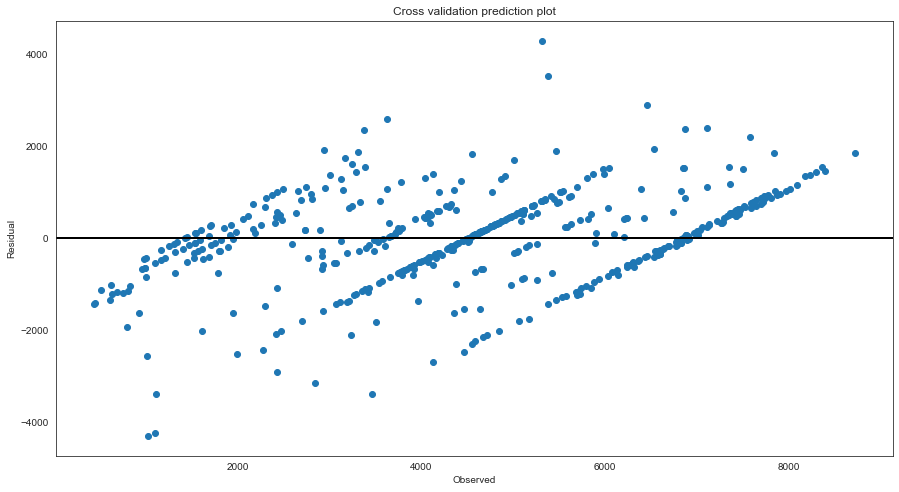

In [186]:
# Cross validation prediction plot
fig,ax=plt.subplots(figsize=(15,8))
ax.scatter(y_train,y_train-predict)
ax.axhline(lw=2,color='black')
ax.set_title('Cross validation prediction plot')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [187]:
#R-squared scores
r2_scores = cross_val_score(dtr, X_train, y_train, cv=3)
print('R-squared scores :',np.average(r2_scores))

R-squared scores : 0.7294133148789058


# Model performance on test dataset

In [188]:
#predict the model
dtr_pred=dtr.predict(X_test)
dtr_pred

array([6777.95      , 1848.95454545, 3612.69230769, 5277.09375   ,
       6777.95      , 6777.95      , 1848.95454545, 1992.25      ,
       6777.95      , 6777.95      , 1848.95454545, 1992.25      ,
       4465.04444444, 5277.09375   , 1992.25      , 1992.25      ,
       1992.25      , 6777.95      , 4465.04444444, 1848.95454545,
       6777.95      , 6777.95      , 5277.09375   , 1848.95454545,
       1992.25      , 4465.04444444, 1992.25      , 6777.95      ,
       1848.95454545, 5277.09375   , 1848.95454545, 4465.04444444,
       6777.95      , 6777.95      , 6777.95      , 5484.22727273,
       6777.95      , 6777.95      , 4465.04444444, 1848.95454545,
       4465.04444444, 1848.95454545, 6777.95      , 4465.04444444,
       6777.95      , 3612.69230769, 4465.04444444, 6777.95      ,
       6777.95      , 5484.22727273, 4465.04444444, 1848.95454545,
       1992.25      , 4465.04444444, 4465.04444444, 4465.04444444,
       3170.41666667, 4465.04444444, 4465.04444444, 6777.95   

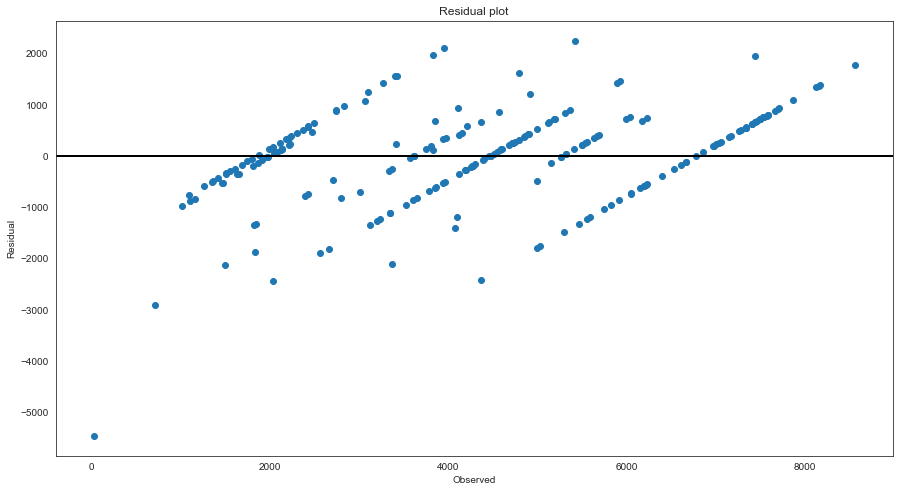

In [189]:
#Residual scatter plot
residuals = y_test-dtr_pred
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
ax.set_title('Residual plot')
plt.show()

# Random Forest

In [190]:
#Training the model
from sklearn.ensemble import RandomForestRegressor
X_train=train_encoded_attributes
rf=RandomForestRegressor(n_estimators=200)
#Fit the trained model
rf.fit(X_train,y_train)
#accuracy of the model
rf_score =rf.score(X_train,y_train)
print('Accuracy of the model :',rf_score)

Accuracy of the model : 0.9812870025949594


# Cross validation prediction

In [191]:
#Cross validation prediction
predict=cross_val_predict(rf,X_train,y_train,cv=3)
predict

array([4995.715, 4790.275, 5273.72 , 4755.92 , 2997.74 , 5793.08 ,
       6669.24 , 3881.35 , 4331.24 , 3663.135, 5971.675, 3409.205,
       4259.605, 7032.365, 4924.37 , 6584.905, 4038.14 , 2643.465,
       1164.7  , 1319.35 , 6218.19 , 3325.8  , 4841.395, 4352.885,
       7115.545, 6264.415, 3231.085, 4172.835, 1446.055, 4972.755,
       1109.91 , 1828.29 , 1477.195, 1984.42 , 4742.75 , 4966.93 ,
       6893.89 , 3967.365, 4334.44 , 6092.945, 6635.82 , 4331.85 ,
       7178.715, 6465.4  , 4446.48 , 3352.985, 1280.605, 3948.405,
       4660.01 , 6535.305, 2982.155, 6537.18 , 6268.61 , 3438.51 ,
       4969.135, 3203.93 , 1388.39 , 4205.54 , 1049.36 , 4651.27 ,
       5491.71 , 4128.39 , 3557.225, 5609.78 , 4401.535, 6974.13 ,
       4651.765, 3145.78 , 3856.31 , 4301.06 , 3741.585, 4452.855,
       7169.72 , 3751.835, 5015.86 , 2450.395, 2409.545, 4623.51 ,
       2053.81 , 4316.845, 4340.705, 4757.085, 4162.06 , 2067.145,
       7526.065, 4293.925, 4694.05 , 7174.275, 4641.79 , 4173.

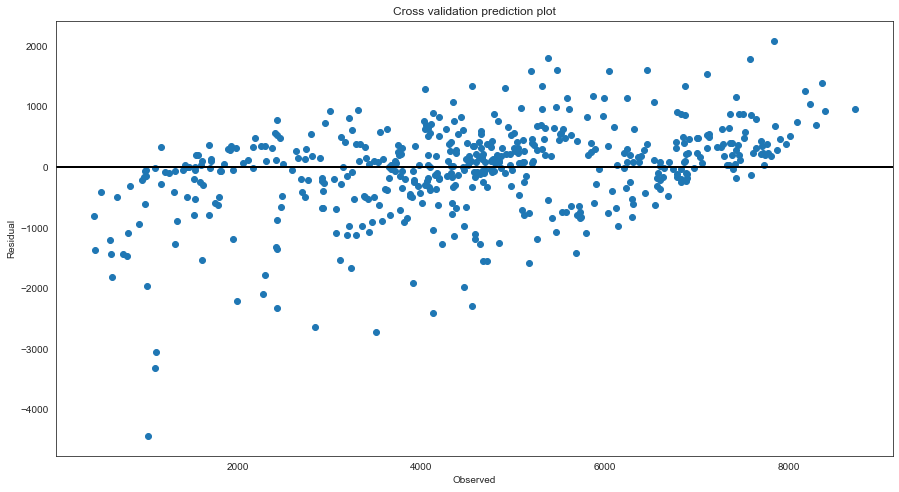

In [192]:
#Cross validation prediction plot
fig,ax=plt.subplots(figsize=(15,8))
ax.scatter(y_train,y_train-predict)
ax.axhline(lw=2,color='black')
ax.set_title('Cross validation prediction plot')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [193]:
#R-squared scores
r2_scores = cross_val_score(rf, X_train, y_train, cv=3)
print('R-squared scores :',np.average(r2_scores))

R-squared scores : 0.846789327578669


# Model performance on test dataset

In [194]:
#predict the model
X_test=test_encoded_attributes
rf_pred=rf.predict(X_test)
rf_pred

array([6570.435, 1553.28 , 3426.56 , 5168.995, 7461.12 , 7232.335,
       1473.45 , 2270.605, 7376.385, 6411.745, 2106.205, 2924.965,
       4985.105, 5025.92 , 2120.605, 2094.31 , 2234.955, 7854.15 ,
       5053.005, 2476.7  , 7448.155, 5948.2  , 5880.29 , 1794.47 ,
       1707.21 , 4764.275, 1955.4  , 7216.885, 3191.945, 5659.795,
       2969.56 , 4076.425, 6619.35 , 7325.   , 6201.06 , 5382.23 ,
       7205.785, 6309.605, 3128.91 ,  942.7  , 3793.825, 3332.945,
       7281.215, 4521.725, 6953.9  , 2184.135, 4351.43 , 5687.805,
       6662.225, 4079.445, 4180.95 , 2923.38 , 2269.61 , 4211.895,
       4716.09 , 4239.98 , 3433.535, 3784.15 , 4306.815, 6573.955,
       6231.615, 6838.92 , 1999.3  , 7341.215, 6587.775, 6397.58 ,
       5889.295, 4276.76 , 1886.105, 7318.63 , 3616.005, 2129.105,
       3133.395, 3904.405, 4231.64 , 3872.825, 4789.565, 4513.015,
       1337.62 , 4318.37 , 2265.925, 1992.375, 5047.185, 4103.465,
       3626.08 , 3457.545, 4101.74 , 3717.91 , 3460.2  , 3392.

In [195]:
#Root mean square error
import math
rmse = math.sqrt(metrics.mean_squared_error(y_test,rf_pred))
print('Root mean square error :',rmse)
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,rf_pred)
print('Mean absolute error :',mae)

Root mean square error : 632.3433269375901
Mean absolute error : 418.8348181818181


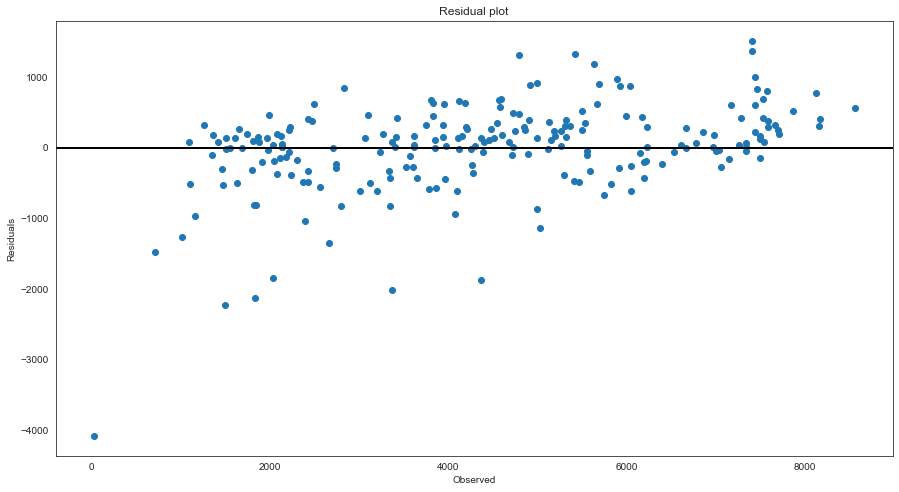

In [196]:
#Residual scatter plot
fig, ax = plt.subplots(figsize=(15,8))
residuals=y_test-rf_pred
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.set_title('Residual plot')
plt.show()

# Final model for predicting the bike rental count on daily basis

In [197]:
Bike_df1=pd.DataFrame(y_test,columns=['y_test'])
Bike_df2=pd.DataFrame(rf_pred,columns=['rf_pred'])
Bike_predictions=pd.merge(Bike_df1,Bike_df2,left_index=True,right_index=True)
Bike_predictions.to_csv('Bike_Renting_Python.csv')
Bike_predictions

,y_test,rf_pred
0,6606,6570.435
1,1550,1553.280
2,3747,3426.560
3,6041,5168.995
4,7538,7461.120
...,...,...
215,2659,4010.305
216,7338,7269.445
217,6978,6800.965
218,4795,3481.175
